# Linear algebra Homework assignment 3

In [49]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## Problem 1 - 4

In [50]:
def compute_lookat(azim: float, elev: float):
    """
    將方位角(azimuth)和仰角(elevation)轉換為觀察向量
    azim: 方位角 [-180, 180]
    elev: 仰角 [-180, 180]
    """
    # 將角度轉換為弧度
    azim_rad = np.radians(azim)
    elev_rad = np.radians(elev)
    
    # 根據球面坐標系公式計算
    x = np.cos(elev_rad) * np.sin(azim_rad)
    y = -np.cos(elev_rad) * np.cos(azim_rad)
    z = np.sin(elev_rad)
    
    lookat = np.array([x, y, z])
    # 標準化向量
    lookat = lookat / np.linalg.norm(lookat)
    
    return lookat

In [51]:
def compute_normal(P1: tuple, P2: tuple, P3: tuple):
    """
    計算三角形面的法向量
    P1, P2, P3: 三角形三個頂點(逆時針順序)
    """
    # 計算三角形兩邊的向量
    v1 = np.array(P2) - np.array(P1)
    v2 = np.array(P3) - np.array(P1)
    
    # 計算叉積得到法向量
    normal = np.cross(v1, v2)
    
    # 標準化法向量
    normal = normal / np.linalg.norm(normal)
    
    return normal

In [52]:
def visible(face_normal: np.ndarray, lookat: np.ndarray):
    """
    判斷面是否可見
    face_normal: 面的法向量
    lookat: 觀察方向
    """
    # 計算法向量與觀察方向的點積
    # 如果點積 < 0,表示夾角>90度,面向觀察者
    return np.dot(face_normal, lookat) < 0

In [53]:
def compute_intensity(face_normal: np.ndarray, lookat: np.ndarray, lightsource: np.ndarray):
    """
    計算光照強度
    face_normal: 面的法向量
    lookat: 觀察方向
    lightsource: 光源方向
    """
    # 計算反射向量 R = 2(N·L)N - L
    NdotL = np.dot(face_normal, lightsource)
    reflect = 2 * NdotL * face_normal - lightsource
    
    # 標準化反射向量
    reflect = reflect / np.linalg.norm(reflect)
    
    # 計算反射向量與觀察向量的夾角餘弦值(cos β)
    intensity = np.dot(reflect, -lookat)
    
    # 確保強度非負
    intensity = max(0, intensity)
    
    return intensity

## Problem 5
Perform at least two tasks from the following list, and describe what you have done

- Change a model (please choose a convex object).
- Give each face of the model a different color.
- Change the movemnt of the light source.
- Other interesting changes

In [54]:
def read_obj_file(file_path):
    vertices = []
    faces = []

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):
                vertex = list(map(float, line.strip().split()[1:]))
                vertices.append(vertex)
            elif line.startswith('f '):
                face = [int(index.split('/')[0]) for index in line.strip().split()[1:]]
                faces.append(face)

    return np.array(vertices), np.array(faces)

IndexError: index 12 is out of bounds for axis 0 with size 12

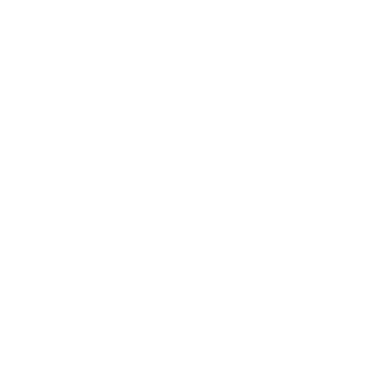

In [ ]:
# The code below is just some hint for you. Feel free to modify anything if you want!

# Read .obj file
obj_file_path = 'icosahedron_modified.obj'
vertices, faces = read_obj_file(obj_file_path)

center = np.mean(vertices, axis=0)
vertices = vertices - center

max_x = np.max(vertices[:, 0])
min_x = np.min(vertices[:, 0])
max_y = np.max(vertices[:, 1])
min_y = np.min(vertices[:, 1])
max_z = np.max(vertices[:, 2])
min_z = np.min(vertices[:, 2])


# Plot vertices
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_axis_off()
ax.set_xlim(min_x, max_x), ax.set_ylim(min_y, max_y), ax.set_zlim(min_z, max_z)
ax.view_init(azim=60, elev=30)

lookat = compute_lookat(ax.azim, ax.elev)
basecolor = np.array([0, 1, 0.7])

phi = 2 * np.pi
lightsource = np.array([np.cos(phi), np.sin(phi), np.sin(phi)])
lightsource = lightsource / np.linalg.norm(lightsource)

# [TODO] Plot faces
######## write you code below


#########

#plt.show()
studentID = 'your_student_id'  # replace to your own studentID!
fname = f'HW3 {studentID}.png'
plt.savefig(fname)


## Problem 6
There is a type of terms, called **vn** (vertex normal), in the obj file.
However, it record vn as each

Please look up the definition of vertex normal and implement it accordingly. The OBJ
file with the corrected vertex normals is icosahedron modified.obj.

In [ ]:
from collections import defaultdict

def load_obj(file_path):
    vertices = []
    faces = []
    vertex_normals = []

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue

            values = line.split()
            if not values:
                continue

            if values[0] == 'v':
                vertices.append([float(x) for x in values[1:4]])
            elif values[0] == 'vn':
                vertex_normals.append([float(x) for x in values[1:4]])
            elif values[0] == 'f':
                vertex_indices = []
                normal_indices = []

                for vertex in values[1:]:
                    # deal with v//vn 
                    if '//' in vertex:
                        v_idx, _, n_idx = vertex.split('/')
                        vertex_indices.append(int(v_idx) - 1)  
                        normal_indices.append(int(n_idx) - 1)
                    # deal with v
                    else:
                        vertex_indices.append(int(vertex) - 1)

                faces.append(vertex_indices)  

    return np.array(vertices), np.array(faces), np.array(vertex_normals)

In [ ]:
def compute_vertex_normals(vertices, faces):
    """
    計算頂點法向量
    vertices: 頂點座標陣列
    faces: 面的頂點索引陣列
    """
    vertex_normals = np.zeros_like(vertices)
    vertex_counts = np.zeros(len(vertices))
    
    # 遍歷所有面
    for face in faces:
        # 取得三個頂點
        v1, v2, v3 = vertices[face[0]], vertices[face[1]], vertices[face[2]]
        
        # 計算面法向量
        normal = compute_normal(v1, v2, v3)
        
        # 將面法向量加到相關頂點
        vertex_normals[face[0]] += normal
        vertex_normals[face[1]] += normal
        vertex_normals[face[2]] += normal
        
        # 記錄每個頂點參與的面數
        vertex_counts[face[0]] += 1
        vertex_counts[face[1]] += 1
        vertex_counts[face[2]] += 1
    
    # 對每個頂點法向量取平均
    for i in range(len(vertex_normals)):
        if vertex_counts[i] > 0:
            vertex_normals[i] = vertex_normals[i] / vertex_counts[i]
            # 標準化
            vertex_normals[i] = vertex_normals[i] / np.linalg.norm(vertex_normals[i])
    
    return vertex_normals

In [ ]:
obj_path = "icosahedron_modified.obj"
vertices, faces, vn = load_obj(obj_path)
vertex_normals = compute_vertex_normals(vertices, faces)

# print("vertex normal：")
# for i, normal in enumerate(vertex_normals):
#     print(f"v{i+1:02d} normal: [{normal[0]:.6f}, {normal[1]:.6f}, {normal[2]:.6f}]")

if (np.allclose(vertex_normals, vn)):
    print("PASS")
else :
    print("ERROR")

PASS
